Questions to:

josh.johnston@kount.com

Notes on SVMs and the Kernel Hack:

https://arxiv.org/pdf/0904.3664v1.pdf

Conceptual diagram of multiclass SVM from the Scikit documentation:

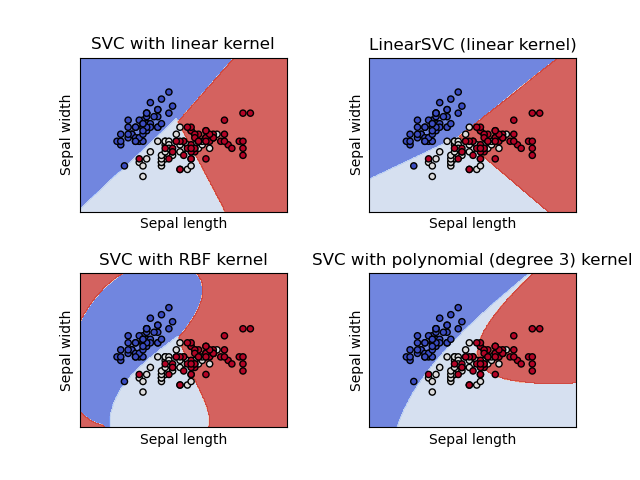

Paper that this notebook vaguely implements:

https://www.researchgate.net/profile/Tomaso_Poggio/publication/2465384_Trainable_Pedestrian_Detection/links/0fcfd50e6dd3120a16000000.pdf

The main difference is that I convert to grayscale instead of dealing with RGB.



In [1]:
anno_dir_name = '/Users/jmj/local/MLClass/data/PennFudanPed/Annotation'
data_dir = '/Users/jmj/local/MLClass/data/'

import cv2

import os
(_, _, anno_filenames) = next(os.walk(anno_dir_name))

annos = []
for anno_filename in anno_filenames:
    new_anno = {}
    anno_file_lines = open(os.path.join(anno_dir_name, anno_filename), 'r').readlines()
    
    # Extract image filename
    new_anno = {'image_file': [x.split('Image filename : "')[1].split('"\n')[0] for x in anno_file_lines if 'Image filename : ' in x][0],
                'upper_left': [],
                'lower_right': [],
                'roi': []}
    
    # Load image from file
    new_anno['image'] = cv2.cvtColor(cv2.imread(os.path.join(data_dir, new_anno['image_file'])), cv2.COLOR_BGR2GRAY)
    
    # Parse bounding boxes from file and extract ROIs from image
    for line in anno_file_lines:
        if 'Bounding box for object ' in line:
            bounding_box_list = line.split('(Xmin, Ymin) - (Xmax, Ymax) : (')[1].split(')\n')[0].split(') - (')
            new_anno['upper_left'].append([int(x) for x in bounding_box_list[0].split(', ')])
            new_anno['lower_right'].append([int(x) for x in bounding_box_list[1].split(', ')])
            new_anno['roi'].append(new_anno['image'][new_anno['upper_left'][-1][1]:new_anno['lower_right'][-1][1],
                                                     new_anno['upper_left'][-1][0]:new_anno['lower_right'][-1][0]])
    annos.append(new_anno)



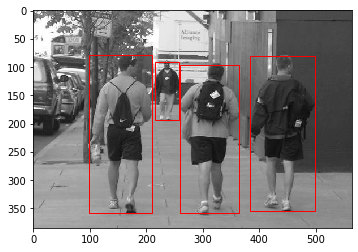

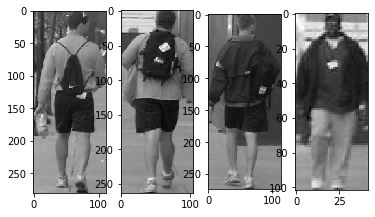

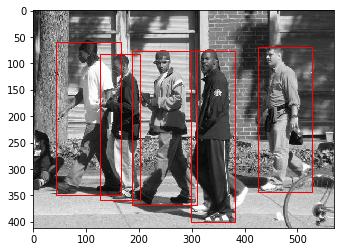

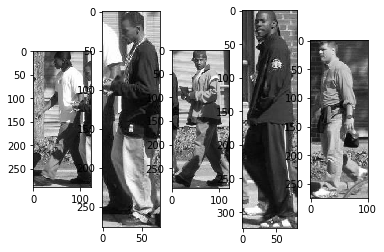

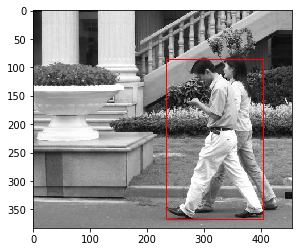

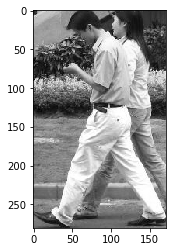

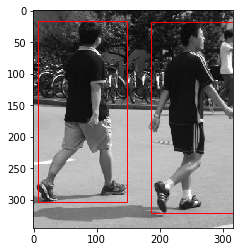

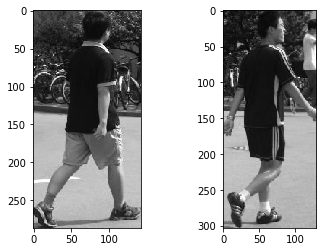

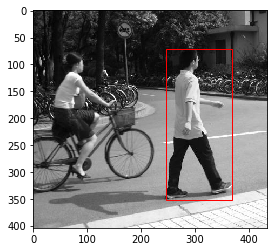

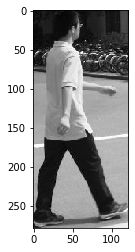

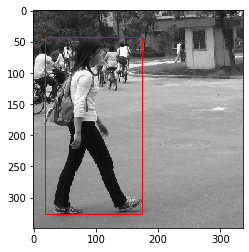

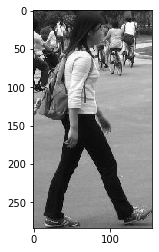

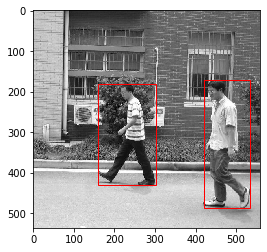

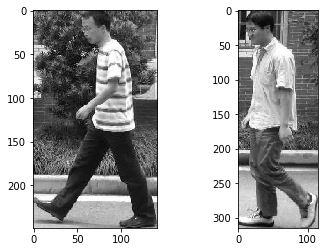

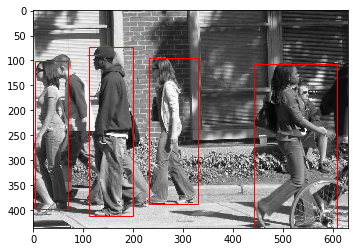

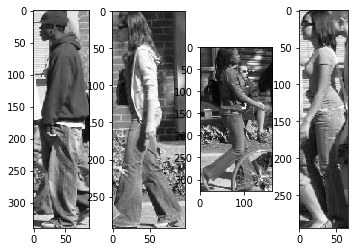

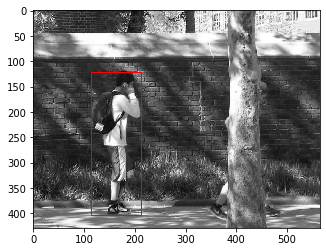

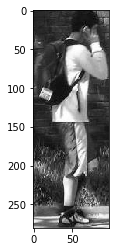

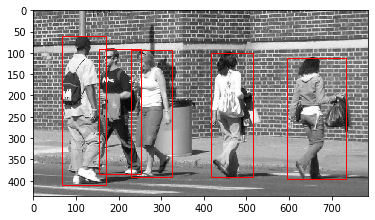

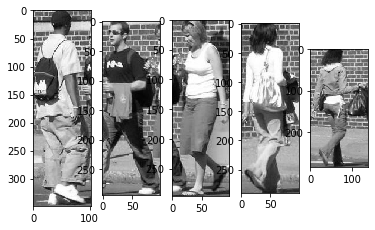

In [2]:
import matplotlib.pyplot

def showAnnototations(annos, count=None, tag=''):
    if count is None:
        count = len(annos)
    
    for anno in annos[0:count]:
        fig, ax_main = matplotlib.pyplot.subplots(1)   
        ax_main.imshow(anno['image'], cmap='gray')
        fig, ax = matplotlib.pyplot.subplots(1, len(anno['upper_left' + tag]))
        for i, (upper_left, lower_right) in enumerate(zip(anno['upper_left' + tag], anno['lower_right' + tag])):
            ax_main.add_patch(matplotlib.patches.Rectangle(upper_left, 
                                                          lower_right[0] - upper_left[0], 
                                                          lower_right[1] - upper_left[1], 
                                                          facecolor='none',
                                                          linewidth=1,
                                                          edgecolor='r'))
            if len(anno['upper_left' + tag]) > 1:
                subplot = ax[i]
            else:
                subplot = ax
            subplot.imshow(anno['image'][upper_left[1]:lower_right[1],
                                         upper_left[0]:lower_right[0]],
                           cmap='gray')

showAnnototations(annos, count=10)


# Getting the ROIs the same size
* We can resample, but what about the aspect ratio?
 * Stretching
 * Changing bounding box limits
* Use domain knowledge:
 * Height varies less than width
 * Width is usually driven by arm and leg posture, which is inconstant, anyway

ROI Height, Width: 128, 64
ROI Aspect Ratio: 2.0


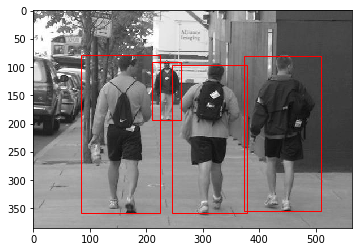

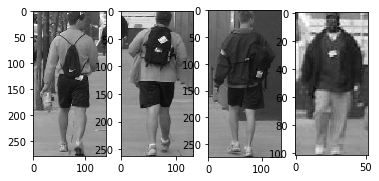

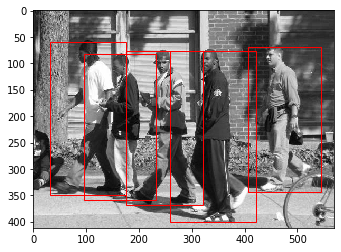

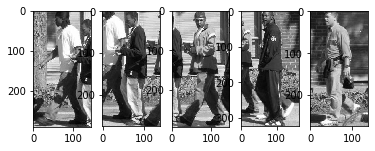

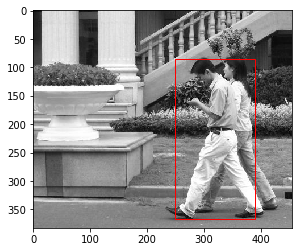

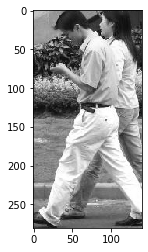

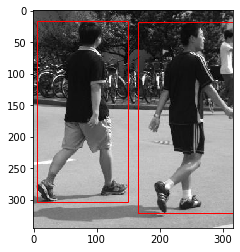

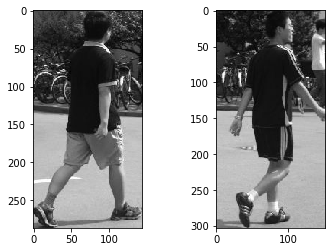

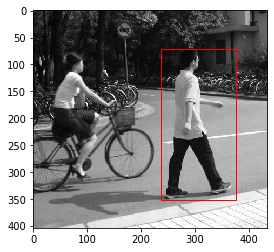

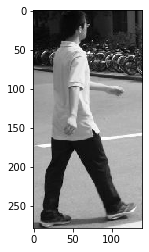

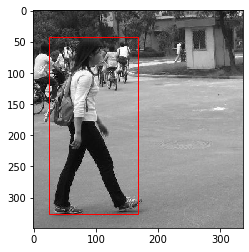

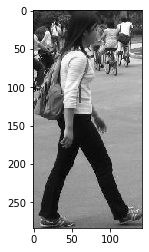

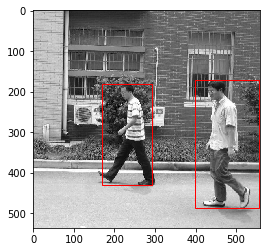

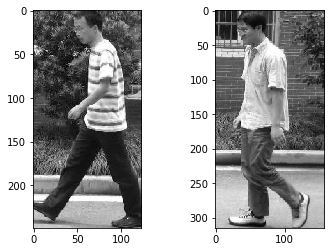

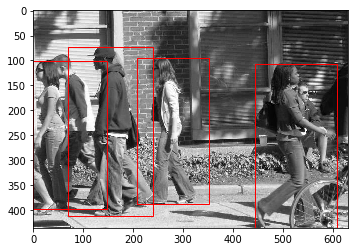

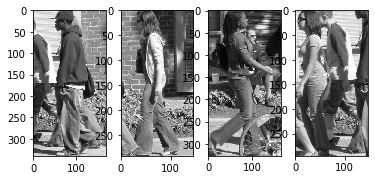

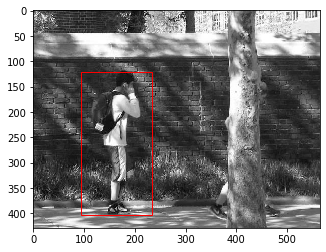

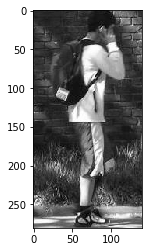

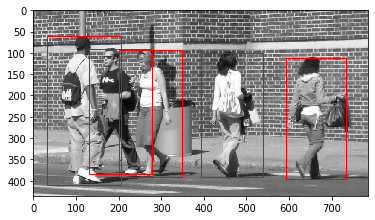

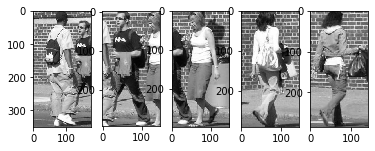

In [3]:
roi_height = 128
roi_width = 64
#roi_width = None

import numpy

def scaleROI(im, left, right, top, bottom, final_width, final_height):
    roi_modified = im[top:bottom, left:right]
    return cv2.resize(roi_modified, (final_width, final_height))


if roi_width is None:
    aspect_ratio_sum = 0
    roi_count = 0
    for anno in annos:
        roi_count += len(anno['upper_left'])
        for (upper_left, lower_right) in zip(anno['upper_left'], anno['lower_right']):
            span = numpy.array(lower_right) - numpy.array(upper_left)
            aspect_ratio_sum += span[1] / span[0]

    aspect_ratio = aspect_ratio_sum / roi_count

    roi_width = int(round(roi_height / aspect_ratio))
else:
    aspect_ratio = roi_height / roi_width
print('ROI Height, Width: {}, {}'.format(roi_height, roi_width))
print('ROI Aspect Ratio: {}'.format(aspect_ratio))

# Extract standard-sized ROIs
for anno in annos:
    anno['lower_right_modified'] = []
    anno['upper_left_modified'] = []
    anno['roi_standardized_positive'] = []
    for i, (upper_left, lower_right) in enumerate(zip(anno['upper_left'], anno['lower_right'])):    
        roi_height_original = lower_right[1] - upper_left[1]
        roi_width_modified = int(round(roi_height_original / aspect_ratio))
        roi_middle_horiz = int(round((lower_right[0] + upper_left[0]) / 2))
        roi_half_width = int(round(roi_width_modified / 2))
        anno['lower_right_modified'].append([roi_middle_horiz + roi_half_width, lower_right[1]])
        anno['upper_left_modified'].append([roi_middle_horiz - roi_half_width, upper_left[1]])
        
        # Shift the ROI if it's off the edge of the image
        roi_left_side = anno['upper_left_modified'][-1][0]
        if(roi_left_side < 0):
            anno['lower_right_modified'][-1] = [anno['lower_right_modified'][-1][0] - roi_left_side, anno['lower_right_modified'][-1][1]]
            anno['upper_left_modified'][-1] = [0, anno['upper_left_modified'][-1][1]]
        roi_right_side = anno['lower_right_modified'][-1][0]
        if(roi_right_side > anno['image'].shape[1]):
            anno['upper_left_modified'][-1] = [anno['upper_left_modified'][-1][0] - (roi_right_side - anno['image'].shape[1]), anno['upper_left_modified'][-1][1]]
            anno['lower_right_modified'][-1] = [anno['image'].shape[1], anno['lower_right_modified'][-1][1]]

        # Create scaled image
        scaled_roi = scaleROI(anno['image'], 
                              left = anno['upper_left_modified'][-1][0], 
                              right = anno['lower_right_modified'][-1][0], 
                              top = anno['upper_left_modified'][-1][1], 
                              bottom = anno['lower_right_modified'][-1][1], 
                              final_width = roi_width, 
                              final_height = roi_height)
        anno['roi_standardized_positive'].append(scaled_roi)
        
        # Flip it... flip it real good
        anno['roi_standardized_positive'].append(cv2.flip(scaled_roi, 1))

        
showAnnototations(annos, count=10, tag='_modified')

# Generate negative data

What should we consider?
* Class balance
* Scales
* Bias in ROI selection
* Image location
* "Hard" cases
* ...


We'll randomly select ROIs of the same size as our annotated ROIs and assume all randomly selected ROIs don't contain humans (bad assumption).

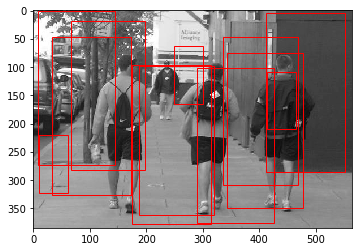

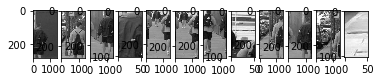

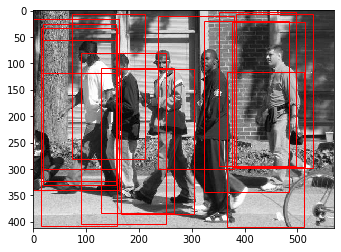

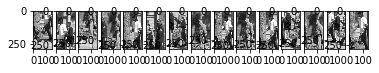

In [4]:
negative_to_positive_ratio = 3

for anno in annos:
    anno['upper_left_negative'] = []
    anno['lower_right_negative'] = []
    anno['roi_standardized_negative'] = []
    for j in numpy.arange(negative_to_positive_ratio):
        for i, (upper_left, lower_right) in enumerate(zip(anno['upper_left_modified'], anno['lower_right_modified'])):
            span = lower_right[0] - upper_left[0], lower_right[1] - upper_left[1]
            left = numpy.random.randint(0, high=anno['image'].shape[1] - span[0])
            right = left + span[0]
            top = numpy.random.randint(0, high=anno['image'].shape[0] - span[1])
            bottom = top + span[1]
            anno['upper_left_negative'].append([left, top])
            anno['lower_right_negative'].append([right, bottom])

            # Create scaled ROI
            scaled_roi = scaleROI(anno['image'], 
                                  left = anno['upper_left_negative'][-1][0], 
                                  right = anno['lower_right_negative'][-1][0], 
                                  top = anno['upper_left_negative'][-1][1], 
                                  bottom = anno['lower_right_negative'][-1][1], 
                                  final_width = roi_width, 
                                  final_height = roi_height)
            
            anno['roi_standardized_negative'].append(scaled_roi)
            
            # Flip it... flip it real good
            anno['roi_standardized_negative'].append(cv2.flip(scaled_roi, 1))

showAnnototations(annos, count=2, tag='_negative')

In [5]:
radii = [8, 16, 32]
overlap = 0.75
        
def haarWaveletReponse(im, center_x, center_y, radius):
    upper_left  = im[(center_y - radius):center_y, (center_x - radius):center_x].sum().astype(numpy.int64)
    upper_right = im[(center_y - radius):center_y, center_x:(center_x + radius)].sum().astype(numpy.int64)
    lower_right = im[center_y:(center_y + radius), center_x:(center_x + radius)].sum().astype(numpy.int64)
    lower_left  = im[center_y:(center_y + radius), (center_x - radius):center_x].sum().astype(numpy.int64)
    return [abs((upper_left + lower_left) - (upper_right + lower_right)) / ((2 * radius)**2),
            abs((upper_left + upper_right) - (lower_left + lower_right)) / ((2 * radius)**2),
            abs((upper_left + lower_right) - (upper_right + lower_left)) / ((2 * radius)**2)] 

def generateFeatureVector(roi, radii, overlap, roi_height, roi_width):
    feature_vector = []
    feature_metadata = []
    for radius in radii:
        for center_y in numpy.arange(radius, roi_height - radius, radius * 2 * (1 - overlap)).astype(int):
            for center_x in numpy.arange(radius, roi_width - radius, radius * 2 * (1 - overlap)).astype(int):
                feature_vector = feature_vector + haarWaveletReponse(roi, center_x, center_y, radius)
    return feature_vector, feature_metadata
    

for anno in annos:
    anno['feature_vector'] = []
    anno['feature_metadata'] = None
    for roi in anno['roi_standardized_positive']: 
        feature_vector, feature_metadata = generateFeatureVector(roi, radii, overlap, roi_height, roi_width)
        anno['feature_vector'].append(feature_vector)
        if(anno['feature_metadata'] is None):
            anno['feature_metadata'] = feature_metadata
    anno['class'] = numpy.ones(len(anno['roi_standardized_positive']))
    for roi in anno['roi_standardized_negative']:
        feature_vector, feature_metadata = generateFeatureVector(roi, radii, overlap, roi_height, roi_width)
        anno['feature_vector'].append(feature_vector)
    anno['class'] = numpy.concatenate((anno['class'], numpy.zeros(len(anno['roi_standardized_negative'])))).tolist()



Training on 555 positive and 1712 negative samples
Feature vector is 1152 long

Training with linear kernel...
  Accuracy: 0.7994628469113697
    tp: 180
    fp: 113
    tn: 713
    fn: 111
  ROC AUC: 0.8390641771298769

Training with poly kernel...
  Accuracy: 0.8442256042972247
    tp: 178
    fp: 61
    tn: 765
    fn: 113
  ROC AUC: 0.8922684572693308

Training with sigmoid kernel...
  Accuracy: 0.6982990152193375
    tp: 99
    fp: 145
    tn: 681
    fn: 192
  ROC AUC: 0.590994566619239

Training with rbf kernel...
  Accuracy: 0.8630259623992838
    tp: 169
    fp: 31
    tn: 795
    fn: 122
  ROC AUC: 0.909708527828395



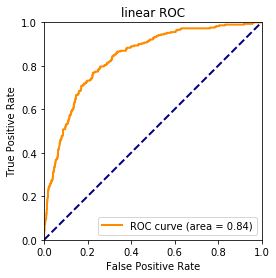

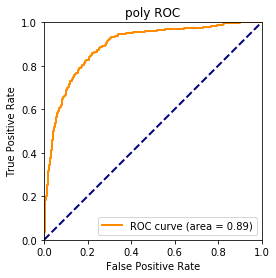

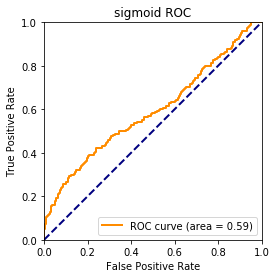

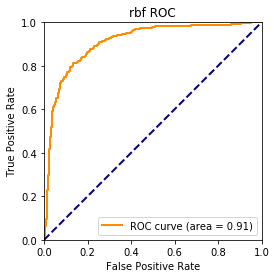

In [7]:
import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

def plotROC(y_test, y_test_scores, kernel):
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_test_scores[:, 1])
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    
    fig, ax = matplotlib.pyplot.subplots(1)
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(kernel + ' ROC')
    ax.set(aspect='equal')
    ax.legend(loc="lower right")
    
    return roc_auc
    
def trainSVM(X_train, X_test, y_train, y_test, kernel='rbf', probability=False):
    print('Training with {} kernel...'.format(kernel))

    clf = sklearn.svm.SVC(kernel=kernel, probability=probability)

    clf.fit(X_train, y_train)

    y_test_pred = clf.predict(X_test)
    print('  Accuracy: {}'.format(sum(y_test == y_test_pred) / len(y_test_pred)))

    confusion = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = confusion.ravel()
    print('    tp: {}'.format(tp))
    print('    fp: {}'.format(fp))
    print('    tn: {}'.format(tn))
    print('    fn: {}'.format(fn))
    
    if (probability is True):
        y_test_scores = clf.predict_proba(X_test)
        roc_auc = plotROC(y_test, y_test_scores, kernel)
        print('  ROC AUC: {}'.format(roc_auc))
    

X = []
y = []
for anno in annos:
    X += anno['feature_vector']
    y += anno['class']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

print('Training on {} positive and {} negative samples'.format(int(sum(y_train)), int(sum(1-numpy.array(y_train)))))
print('Feature vector is {} long'.format(len(X_train[0])))
print()

for kernel in ['linear', 'poly', 'sigmoid', 'rbf']:
    trainSVM(X_train, X_test, y_train, y_test, kernel=kernel, probability=True)
    print()


